In this code we will be implementing some components of neural networks in numpy from scratch (all our code will be vectorized; and we don't use any library besides numpy and matplotlib). Base meta classes for the various activations, layers and optimizers are provided; all of our implementations will be classes that inherit from the appropriate base meta class.

# Step 1: Fully-connected neural networks


## General comments

In this step we will implement all the components we need to construct and train a fully-connected neural network:  the forward and backwards passes for various activations and types of layers, a loss (baked into the SoftMax class), a class to hold the stacked layers together and a couple of optimizers. 

The forward pass is relatively straightforward: each layer outputs an array that the following layer takes as its input. The backwards pass, on the other hand, is a bit more complicated and to be able to complete it, we need to both have the incoming gradient and the original input to each layer, represented by the variable "original_input" in our code. The gradient returned by the backward() call of any given layer is then used as input for the backward() call of the layer immediately preceding it.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import abc

# 1. 

Implement the forwards and backwards passes for the following activations: a) Sigmoid, $\sigma(x) = \frac{1}{1+e^{-x}}$; b) Tanh, tthat returns the tangent hyperbolic function of its input,  $y = tanh(x)$.

Note that defining the __ call __ function allows us to avoid calling the forward function directly, i.e. instead of calling ReLU.forward(x), you should call ReLU(x) instead (for example).

**Derivative of activation functions**

$o = sig(x) ==> \frac{dO}{dx} = o(1-o) = sig(x)*(1-sig(x))$

$o = tanh(x) ==> \frac{dO}{dx} = 1 - (np.tanh(x)^2)$

In [ ]:
# Abstract base class for all activation classes
class Activations(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def forward(self, x):
        return

    @abc.abstractmethod
    def backward(self, grad, original_input):
        return


class ReLU(Activations):
    def forward(self, x):
        # return result
        return np.maximum(0, x)

    def backward(self, grad, original_input):
        # this assumes that the original input to this layer has been saved somewhere else
        x = original_input
        return grad * (x > 0)

    def __call__(self, x, mode=None):
        return self.forward(x)


class Sigmoid(Activations):
    def forward(self, x):
        return 1 / 1 + np.exp(-x)

    def backward(self, grad, original_input):
        # o = sig(x) ==> dOdx = o(1-o) = sig(x)*(1-sig(x))
        x = original_input
        sig = 1 / 1 + np.exp(-x)
        return grad * sig * (1 - sig)

    def __call__(self, x, mode=None):
        return self.forward(x)


class Tanh(Activations):
    def forward(self, x):
        return np.tanh(x)

    def backward(self, grad, original_input):
        # o = tanh(x) ==> dOdx = (sech(x))^2 = 1 / (cosh(x))^2
        x = original_input
        return grad * (1 - (np.tanh(x) ** 2))

    def __call__(self, x, mode=None):
        return self.forward(x)

# 2.

Implement an activation (“SoftmaxCrossLoss”) that has two modes of operation: a) if a target, $y_{true}$, is provided then it operates in the same manner as the Pytorch CrossEntropyLoss (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) (basically the usual softmax activation plus a cross-entropy loss); b) if no target $y_{true}$ is provided, then the forward pass just returns the softmax of the input (no backwards pass needs to be implemented for this mode): for a vector $\mathbf{x}=(x_1,x_2, \cdots, x_n)$, Softmax$(\mathbf{x})_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$ (when using batches this operation should be done for each vector in the batch). 

While implementing softmax shift our input by using shifted_x = x - np.max(x, axis=1, keepdims=True). This does not affect the result of the softmax operation and improves numerical stability.

Note that "mode" is included in this class's function calls just to keep a unified interface for use in the fully-connected neural network.

$\mathbf{}$Cross entropy loss = $\mathbf L(y,p)=-\frac{1}{N}\sum_i y_i log(p_i)$

$p_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$

$\frac{dL}{dx} = \frac{dL}{dp_i} * \frac{dp_i}{dx} = p_i - y_i$

In [ ]:
class SoftMaxCrossLoss(Activations):
    def __init__(self):
        self.probs = None
        self.y = None

    def forward(self, x, y=None):

        shifted_x = x - np.max(x, axis=1, keepdims=True)

        e = np.exp(shifted_x)
        probability = e / e.sum()

        if y is None:  # y being none should make this return simply a softmax activation: we are in testing mode
            return probability
        else:  # y is not none, you should return the cross-entropy loss using the softmax activations
            self.y = y.T
            ll = -np.log(probability+1e-8) * self.y  # zarbe deraye be deraye
            # print("heeee", ll.shape[0])
            # print("heeee", ll.shape[1])
            return np.sum(ll) / (ll.shape[0] * ll.shape[1])  # loss

    def backward(self, grad, original_input):

        x = original_input
        shifted_x = x - np.max(x, axis=1, keepdims=True)

        e = np.exp(x)
        y_pred = e / e.sum()

        soft_grad = y_pred - self.y

        return grad * soft_grad

    def __call__(self, x, y=None, mode=None):
        return self.forward(x, y)

# 3.

Implement three layers (with both forward and backwards passes): a) an AffineLayer (with input dimension input_dim and hidden units hidden_dim), whose forward pass returns $Y=Xw^T + b$, where w and b are the weights and bias respectively; b) an Inverted Dropout (https://machinelearning.wtf/terms/inverted-dropout/) layer that keeps weights with probability p; c) a BatchNorm layer.

Note that the gradients of the parameters of each layer should be kept inside their respective layers. Dropout and Batchnorm behave different based on whether we are in "train" or "test" mode.

**Affine forward:**

$A = w*input+b$

**Affine layer backward:**

$\frac{dL}{dw}=(\frac{dL}{d_{softmax}}\frac{d{softmax}}{dA})\frac{dA}{dw} = grad * \frac{dA}{dw} = \frac{1}{m} * grad * input^T$

*#m is equal to batch size*

$\frac{dL}{db}=(\frac{dL}{d_{softmax}}\frac{d{softmax}}{dA})\frac{dA}{db} = grad * \frac{dA}{db} = \frac{1}{m} * np.  sum(grad, axis = 1, keepdim = True)$

*#keepdim to prevent array like (n,) and keep 1 in the second dimention (n,1)*

**BatchNorm Layer**

**Forward**

$x_{norm} = \frac{x - \frac{1}{m}Σx_i}{\sqrt{\frac{1}{m}(x_i-𝜇)^2 + 𝛆}}$ 

$y = γ * x_{norm}+β$

**Backward**

$\frac{dy}{dγ} = x_{norm} * grad$

$\frac{dy}{dγ} = grad$

$\frac{dx_{norm}}{d𝜇} = \frac{-1}{\sqrt{δ^2}}$

$\frac{dδ^2}{d𝜇} = -\frac{2}{m}Σ(x_i-𝜇)$

$\frac{dx_{norm}}{dδ^2}=-0.5Σ(x_i-𝜇)(δ^2)^{-1.5}$

$\frac{d𝜇}{dx} = \frac{1}{m}$

$\frac{dδ^2}{dx_i}=\frac{2(x_i-𝜇)}{m}$

$\frac{dy}{dx}=\frac{dy}{dx_{norm}}\frac{dx_{nomr}}{dx}+\frac{dy}{dx_{norm}}\frac{dx_{nomr}}{d𝜇}\frac{d𝜇}{dx}+\frac{dy}{dx_{norm}}\frac{dx_{nomr}}{dδ^2}\frac{dδ^2}{dx}$

**Dropout**

**Forward**

$y=\frac{x * mask}{keep_p}$

*# mask = a matrix that indicate which neuron should be on and which one should be off with the keep_probability*

**Backward**

$\frac{dy}{dx} = grad * \frac{mask}{keep_p}$

In [ ]:
class Layers(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def forward(self, x):
        return

    @abc.abstractmethod
    def backward(self, grad, original_input):
        return


class AffineLayer(Layers):
    def __init__(self, input_dim, hidden_units):
        ran = np.sqrt(1 / input_dim)

        # Initializing the weights and bias, in that order
        self.parameters = [np.random.uniform(-ran, ran, (hidden_units, input_dim)),  # param[0]=w, param[1]=b
                           np.random.uniform(-ran, ran, hidden_units).reshape((hidden_units, 1))]

        # self.parameters = [np.ones((hidden_units, input_dim)) * 0.01,  # param[0]=w, param[1]=b
        #                    np.ones((hidden_units, 1)) * 0.01]

        self.grads = [np.zeros_like(self.parameters[0]), np.zeros_like(self.parameters[1])]  # grad[0]=dw,  grad[1]=db

        self.hist_momentum = [np.zeros((hidden_units, input_dim)), np.zeros((hidden_units, 1))]

        self.hist_rms = [np.zeros((hidden_units, input_dim)), np.zeros((hidden_units, 1))]

    def forward(self, x):
        # x = a_l-1
        return np.dot(self.parameters[0], x) + self.parameters[1]

    def backward(self, grad, original_input):
        m = grad.shape[1]  # number of sample

        self.grads[0] = (1 / m) * np.dot(grad, original_input.T)  # dw
        self.grads[1] = (1 / m) * np.sum(grad, axis=1, keepdims=True)  # db

        # return gradient with respect to the original input to this layer
        grad_x = np.dot(np.transpose(self.parameters[0]), grad)
        return grad_x

    def __call__(self, x, mode=None):
        return self.forward(x)


class BatchNorm(Layers):
    def __init__(self, momentum):
        # Initialize the parameters

        self.parameters = [np.random.rand(), np.random.rand()]  # param[0] = gamma, param[1] = beta

        self.grads = [0, 0]  # grads[0]=d_gamma,  grads[1]=d_beta

        self.hist_momentum = [0, 0]

        self.history = [0, 0]  # history[0] = mean,  history[1] = var

        self.momentum = momentum

    def forward(self, x, mode):
        if mode == "train":
            mu = np.mean(x, axis=1, keepdims=True)
            var = np.var(x, axis=1, keepdims=True)

            x_norm = (x - mu) / np.sqrt(var + 1e-8)  # add eps for numerical stability
            out = self.parameters[0] * x_norm + self.parameters[1]

            # keep history by exponentially weighted average
            self.history[0] = self.momentum * self.history[0] + (1. - self.momentum) * mu
            self.history[1] = self.momentum * self.history[1] + (1. - self.momentum) * var

            return out
        else:
            x_norm = (x - self.history[0]) / np.sqrt(self.history[1] + 1e-8)
            out = self.parameters[0] * x_norm + self.parameters[1]
            return out

    def backward(self, grad, original_input):
        x = original_input
        mu = np.mean(x, axis=1, keepdims=True)
        var = np.var(x, axis=1, keepdims=True)
        x_norm = (x - mu) / np.sqrt(var + 1e-8)

        self.grads[0] = np.sum(x_norm * grad)
        self.grads[1] = np.sum(grad)

        # return gradient with respect to the original input to this layer
        std_inv = 1 / np.sqrt(var + 1e-8)

        dx_norm = grad * self.parameters[0]
        dvar = np.sum(dx_norm * (x - mu), axis=1, keepdims=True) * -0.5 * std_inv ** 3
        dmu = np.sum(dx_norm * -std_inv, axis=1, keepdims=True) + dvar * np.mean(-2. * (x - mu), axis=1, keepdims=True)

        grad_x = (dx_norm * std_inv) + (dvar * 2 * (x - mu) / x.shape[0]) + (dmu / x.shape[0])
        return grad_x


class Dropout(Layers):
    def __init__(self, p):
        self.keep_p = p
        self.mask = None

    def forward(self, x, mode):
        if mode == "train":
            self.mask = np.random.binomial(1, self.keep_p, size=x.shape)
            return x * self.mask / self.keep_p
        else:
            return x

    def backward(self, grad, original_input):

        # return gradient with respect to the original input to this layer
        return grad * self.mask / self.keep_p

    def __call__(self, x, mode="test"):
        return self.forward(x, mode)

# 4.

Implement a fully connected neural network that takes as input some user-defined layers and has both forward and backward passes.

In [ ]:
class FCNN:
    def __init__(self, layers):
        self.layers = layers
        self.original_inputs = []

    def forward(self, x, y=None, mode='test'):
        # Start by adding the input to the original_inputs array that keeps the original_input to each
        # layer in order.
        self.original_inputs = [x.copy()]
        for i in range(len(self.layers)):
            layer = self.layers[i]
            # print("namosan ", i)
            # print(self.original_inputs[i])
            if isinstance(layer, BatchNorm) or isinstance(layer, Dropout):
                self.original_inputs.append(layer.forward(self.original_inputs[-1], mode))

            elif isinstance(layer, SoftMaxCrossLoss):
                self.original_inputs.append(layer.forward(self.original_inputs[-1], y))

            else:
                self.original_inputs.append(layer.forward(self.original_inputs[-1]))

        return self.original_inputs[-1]  # y_hat

    def backward(self):
        # Pop loss value from the cache
        k = self.original_inputs.pop()
        grad = [1]  # None

        network_depth = len(self.original_inputs)
        for i in range(network_depth):
            original_input = self.original_inputs.pop()
            layer = self.layers[-(i + 1)]
            grad.append(layer.backward(grad[-1], original_input))

        # This should be the grad w.r.t input only
        return grad

    def __call__(self, x, y=None, mode='test'):
        return self.forward(x, y, mode)

# 5.

Implement the following optimizers: a) stochastic gradient descent with momentum; b) The Adam optimizer (https://pytorch.org/docs/stable/generated/torch.optim.Adam.html). These optimizers should take as input a layer and update their parameters according to the gradients stored in the layers.

Note that Adam requires you to keep a track of the running means of gradients. A python dictionary to organize this might prove useful.

In [ ]:
class Optimizer(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def step(self, layer):
        return


class SGD(Optimizer):
    def __init__(self, momentum, learning_rate):
        self.l = learning_rate
        self.momentum = momentum

    def step(self, layer):
        for i in range(len(layer.parameters)):
            layer.hist_momentum[i] = (self.momentum * layer.hist_momentum[i]) + ((1 - self.momentum) * layer.grads[i])

            layer.parameters[i] = layer.parameters[i] - self.l * layer.hist_momentum[i]


class Adam(Optimizer):
    def __init__(self, learning_rate, momentum, rms):
        # Initialize the parameters you need.
        self.l = learning_rate
        self.momentum = momentum
        self.r = rms

    def step(self, layer):
        for i in range(len(layer.parameters)):
            layer.hist_momentum[i] = (self.momentum * layer.hist_momentum[i]) + ((1 - self.momentum) * layer.grads[i])
            layer.hist_rms[i] = (self.r * layer.hist_rms[i]) + ((1 - self.r) * (layer.grads[i]) ** 2)

            norm_m = layer.hist_momentum[i] / (1 - self.momentum)
            norm_r = layer.hist_rms[i] / (1 - self.r)

            layer.parameters[i] = layer.parameters[i] - self.l * (norm_m / np.sqrt(norm_r + 1e-8))

# 6.

Test out several fully connected architectures on the reduced MNIST dataset provided. Feed the dataset to our network in batches and experiment with the batch size. 

a) Experiment with the batch size. Does the batch size impact performance? 
<br>
If we choose batch size exactly the same as input data, it will take too much time too run and we have to wait too long for just one single update. on the other hand if we choose batch size equal to 1 the mini-batch turn to a stochastic gradian desent which is not sufficient for such a big dataset. since for each single data we run the forward and backward algorithm. So, I choose 10, 100, 600 and 1000 as my batch size. I observed that, when I choose a small number like 10, because it's only report the error of 10 sample, the loss is much more smaller than batch size 1000. which is kinda obvious. As a result, I choose 1000 as my batch size because with 100 It takes too much time for me to see the results and improvement of my code. and in this way we devide dataset into 60 smaller dataset which is resonable.

b) Do you do better with two or three layers? Experiment with the hidden units in each layers.

I tried three differnet network:
<br>
1- two hidden layer (Affine layer + RelU) with (Affine + Softmax).
<br>
2- three hidden layer: fisrt = Affine+ReLU and second = Affine+softmax
<br>
3- four hidden layer : first and second = Affine+ReLU and third = Affine + softmax
<br>
I got the best result in first and second network. but with 3 layer, my values just burst and I have infinite! I guess the reason is that in deep networks after a while because of gradient vanishing, the gradient will be too small and it multiply to our data and prediction. so in the softmax layer when I took the log of such small value which is close to 0 it turns to an infinite number. However, with first network, the learning curve is so smooth and is decreasing over time.
<br>
I tried the number of hidden unit as follow for each network:
<br>
1- 784 (input) , 256 (Affine), 10 (softmax)

2- 784 - 400 - 100 - 10

3- 784 - 600 - 400 - 100 - 10 

As I mentioned before, I got the best results in first one.

c) Does adding more layers continually improve your results? 

No, when I increased the number of layer, my network burst and I got inf values.

d) Does Dropout help? 

since I had overflow in the C part, I add a dropout layer to each of my hidden layers, I saw that it helped the network to prevent it from overfitting. And my network resist longer, so for example if I had overflow in epoc 15 previously, with droupout I had overflow in epoch 40.

e) What can you say about the difficulty of training as you add layers? 

As we increase the size of the network, we are making it more powerful, with more parameters. so we are reducing the generalization of the model at the same time parameter fine tuning is more defiicult because we have to be supper carefull abouot all of them.

f) Does Batchnorm improve results? 


when I got depth in to the output and debugging, I saw that when I have inf in my values the probability array in softmax neuron contain two different range of value! one of them was so big ! so big ! the one that we expect to be the asnwers as the class number, and the rest of the values were so small, almost near to zero! so that was the reason of inf numbers. So I add a BatchNorm layer before my softmax, to normilized the input array to softmax, so in this way a balance will happend and number will be more close to each other.

g) Try using the Adam optimizer. Do you converge more quickly? Do you get better results?

Adam optimizer was incredibly more faster than SGD, but since it make the steps in weight direction bigger than, bias direction (I mean in the cost curve), it reduce the generalization of model.

2 hidden layer: 784 - 256 - 10
<br>
affine, relu

affine, softmax

batch size = 1000

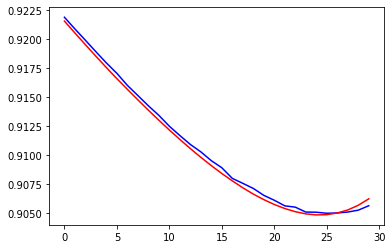

In [ ]:
# Loading the data

train_data = np.load("train.npz")['arr_0']
train_targets = np.load("train.npz")['arr_1']

test_data = np.load("test.npz")['arr_0']
test_targets = np.load("test.npz")['arr_1']

# Flatten data
train_data = np.transpose(train_data.flatten().reshape(60000, 784))  # faghat avalin affine vorodi bayad transpose beshe
test_data = np.transpose(test_data.flatten().reshape(10000, 784))

# converting y to one hot encoder matrix
train_targets_ohe = np.zeros((len(train_targets), 10))
for i in range(len(train_targets)):
    train_targets_ohe[i, train_targets[i]] = 1

test_targets_ohe = np.zeros((len(test_targets), 10))
for i in range(len(test_targets)):
    test_targets_ohe[i, test_targets[i]] = 1

# Defining hyper parameter
batch_size = 1000
learningRate = 0.0001
momentum = 0.9
rms = 0.999
epoch = 30

# defining network
net = FCNN([AffineLayer(784, 256), ReLU(),
            AffineLayer(256, 10), SoftMaxCrossLoss()])

my_optimizer = SGD(momentum, learningRate)
# my_optimizer = Adam(momentum, learningRate, rms)

# _____________________training_____________________
mse_total = []
mse_total_test = []
for i in range(epoch):
    # shuffle data in each epoch
    a = train_data.shape[1]
    shuffler = np.random.permutation(train_data.shape[1])
    x_shuffled = train_data.T[shuffler].T  # transpose, shuffle row, transpose again
    y_shuffled = train_targets_ohe[shuffler]
    # x_shuffled = train_data
    # y_shuffled = train_targets_ohe

    mse_epoc = 0
    mse_epoc_test = 0

    for j in range(0, 60000, batch_size):
        x_batch = x_shuffled[:, j:j + batch_size]  # select range on columns
        y_batch = y_shuffled[j:j + batch_size]  # select range on rows

        forward = net.forward(x_batch, y_batch, "train")  # forward = error
        grads = net.backward()
        for k in range(len(net.layers)):
            if isinstance(net.layers[k], AffineLayer) or isinstance(net.layers[k], BatchNorm):
                my_optimizer.step(net.layers[k])  # updating parameters

        mse_epoc += forward

        # print("______________________________________________________")
        # print(forward)
        # print(grads)
    # test
    for j in range(0, 10000, batch_size):
        x_batch = test_data[:, j:j + batch_size]
        y_batch = test_targets_ohe[j:j + batch_size]  # select range on rows

        forward = net.forward(x_batch, y_batch, "test")  # forward = error

        mse_epoc_test += forward

    mse_total.append(mse_epoc / (60000 / batch_size))
    mse_total_test.append(mse_epoc_test / (10000 / batch_size))
    # print("*********", mse_total[-1])

plt.plot(mse_total,'b')
plt.plot(mse_total_test,'r')

three layer: 784 - 500 - 256 - 10

affine, relu

affine, relu

affine, softmax 

batch size = 1000

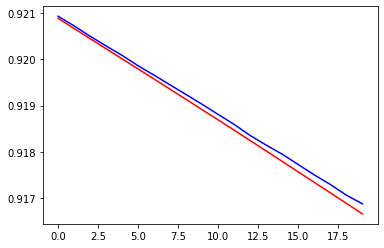

In [ ]:
# Loading the data

train_data = np.load("train.npz")['arr_0']
train_targets = np.load("train.npz")['arr_1']

test_data = np.load("test.npz")['arr_0']
test_targets = np.load("test.npz")['arr_1']

# Flatten data
train_data = np.transpose(train_data.flatten().reshape(60000, 784))  # faghat avalin affine vorodi bayad transpose beshe
test_data = np.transpose(test_data.flatten().reshape(10000, 784))

# converting y to one hot encoder matrix
train_targets_ohe = np.zeros((len(train_targets), 10))
for i in range(len(train_targets)):
    train_targets_ohe[i, train_targets[i]] = 1

test_targets_ohe = np.zeros((len(test_targets), 10))
for i in range(len(test_targets)):
    test_targets_ohe[i, test_targets[i]] = 1

# Defining hyper parameter
batch_size = 1000
learningRate = 0.0001
momentum = 0.9
rms = 0.999
epoch = 20

# defining network
net = FCNN([AffineLayer(784, 500), ReLU(),
            AffineLayer(500, 256), ReLU(),
            AffineLayer(256, 10), SoftMaxCrossLoss()])

my_optimizer = SGD(momentum, learningRate)
# my_optimizer = Adam(momentum, learningRate, rms)

# _____________________training_____________________
mse_total = []
mse_total_test = []
for i in range(epoch):
    # shuffle data in each epoch
    a = train_data.shape[1]
    shuffler = np.random.permutation(train_data.shape[1])
    x_shuffled = train_data.T[shuffler].T  # transpose, shuffle row, transpose again
    y_shuffled = train_targets_ohe[shuffler]
    # x_shuffled = train_data
    # y_shuffled = train_targets_ohe

    mse_epoc = 0
    mse_epoc_test = 0

    # train
    for j in range(0, 60000, batch_size):
        x_batch = x_shuffled[:, j:j + batch_size]  # select range on columns
        y_batch = y_shuffled[j:j + batch_size]  # select range on rows

        forward = net.forward(x_batch, y_batch, "train")  # forward = error
        grads = net.backward()
        for k in range(len(net.layers)):
            if isinstance(net.layers[k], AffineLayer) or isinstance(net.layers[k], BatchNorm):
                my_optimizer.step(net.layers[k])  # updating parameters

        mse_epoc += forward

        # print("______________________________________________________")
        # print(forward)
        # print(grads)
    # test
    for j in range(0, 10000, batch_size):
        x_batch = test_data[:, j:j + batch_size]
        y_batch = test_targets_ohe[j:j + batch_size]  # select range on rows

        forward = net.forward(x_batch, y_batch, "test")  # forward = error

        mse_epoc_test += forward

    mse_total.append(mse_epoc / (60000 / batch_size))
    mse_total_test.append(mse_epoc_test / (10000 / batch_size))
    # print("*********", mse_total[-1])

plt.plot(mse_total,'b')
plt.plot(mse_total_test,'r')

same two layer 

changing batch size from 1000 to 600

adding BatchNorm layer before softmax. without it I had inf values.

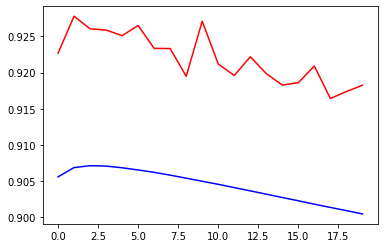

In [ ]:
# Loading the data

train_data = np.load("train.npz")['arr_0']
train_targets = np.load("train.npz")['arr_1']

test_data = np.load("test.npz")['arr_0']
test_targets = np.load("test.npz")['arr_1']

# Flatten data
train_data = np.transpose(train_data.flatten().reshape(60000, 784))  # faghat avalin affine vorodi bayad transpose beshe
test_data = np.transpose(test_data.flatten().reshape(10000, 784))

# converting y to one hot encoder matrix
train_targets_ohe = np.zeros((len(train_targets), 10))
for i in range(len(train_targets)):
    train_targets_ohe[i, train_targets[i]] = 1

test_targets_ohe = np.zeros((len(test_targets), 10))
for i in range(len(test_targets)):
    test_targets_ohe[i, test_targets[i]] = 1

# Defining hyper parameter
batch_size = 600
learningRate = 0.0001
momentum = 0.9
rms = 0.999
epoch = 20

# defining network
net = FCNN([AffineLayer(784, 256), ReLU(),
            AffineLayer(256, 10), BatchNorm(0.1),SoftMaxCrossLoss()])

my_optimizer = SGD(momentum, learningRate)
# my_optimizer = Adam(momentum, learningRate, rms)

# _____________________training_____________________
mse_total = []
mse_total_test = []
for i in range(epoch):
    # shuffle data in each epoch
    a = train_data.shape[1]
    shuffler = np.random.permutation(train_data.shape[1])
    x_shuffled = train_data.T[shuffler].T  # transpose, shuffle row, transpose again
    y_shuffled = train_targets_ohe[shuffler]
    # x_shuffled = train_data
    # y_shuffled = train_targets_ohe

    mse_epoc = 0
    mse_epoc_test = 0

    for j in range(0, 60000, batch_size):
        x_batch = x_shuffled[:, j:j + batch_size]  # select range on columns
        y_batch = y_shuffled[j:j + batch_size]  # select range on rows

        forward = net.forward(x_batch, y_batch, "train")  # forward = error
        grads = net.backward()
        for k in range(len(net.layers)):
            if isinstance(net.layers[k], AffineLayer) or isinstance(net.layers[k], BatchNorm):
                my_optimizer.step(net.layers[k])  # updating parameters

        mse_epoc += forward

        # print("______________________________________________________")
        # print(forward)
        # print(grads)
    # test
    for j in range(0, 10000, batch_size):
        x_batch = test_data[:, j:j + batch_size]
        y_batch = test_targets_ohe[j:j + batch_size]  # select range on rows

        forward = net.forward(x_batch, y_batch, "test")  # forward = error

        mse_epoc_test += forward

    mse_total.append(mse_epoc / (60000 / batch_size))
    mse_total_test.append(mse_epoc_test / (10000 / batch_size))
    # print("*********", mse_total[-1])

plt.plot(mse_total,'b')
plt.plot(mse_total_test,'r')

In below: I added a Dropout layer to my network with keep probability of 0.8.

As you can see it is more smoother than previous one.

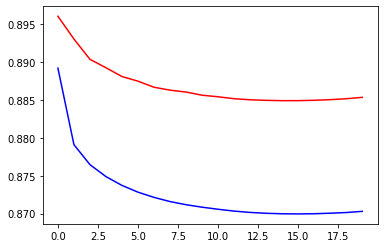

In [ ]:
# Loading the data

train_data = np.load("train.npz")['arr_0']
train_targets = np.load("train.npz")['arr_1']

test_data = np.load("test.npz")['arr_0']
test_targets = np.load("test.npz")['arr_1']

# Flatten data
train_data = np.transpose(train_data.flatten().reshape(60000, 784))  # faghat avalin affine vorodi bayad transpose beshe
test_data = np.transpose(test_data.flatten().reshape(10000, 784))

# converting y to one hot encoder matrix
train_targets_ohe = np.zeros((len(train_targets), 10))
for i in range(len(train_targets)):
    train_targets_ohe[i, train_targets[i]] = 1

test_targets_ohe = np.zeros((len(test_targets), 10))
for i in range(len(test_targets)):
    test_targets_ohe[i, test_targets[i]] = 1

# Defining hyper parameter
batch_size = 600
learningRate = 0.0001
momentum = 0.9
rms = 0.999
epoch = 20

# defining network
net = FCNN([AffineLayer(784, 256), ReLU(), Dropout(0.8),
            AffineLayer(256, 10), BatchNorm(0.1),SoftMaxCrossLoss()])

my_optimizer = SGD(momentum, learningRate)
# my_optimizer = Adam(momentum, learningRate, rms)

# _____________________training_____________________
mse_total = []
mse_total_test = []
for i in range(epoch):
    # shuffle data in each epoch
    a = train_data.shape[1]
    shuffler = np.random.permutation(train_data.shape[1])
    x_shuffled = train_data.T[shuffler].T  # transpose, shuffle row, transpose again
    y_shuffled = train_targets_ohe[shuffler]
    # x_shuffled = train_data
    # y_shuffled = train_targets_ohe

    mse_epoc = 0
    mse_epoc_test = 0

    for j in range(0, 60000, batch_size):
        x_batch = x_shuffled[:, j:j + batch_size]  # select range on columns
        y_batch = y_shuffled[j:j + batch_size]  # select range on rows

        forward = net.forward(x_batch, y_batch, "train")  # forward = error
        grads = net.backward()
        for k in range(len(net.layers)):
            if isinstance(net.layers[k], AffineLayer) or isinstance(net.layers[k], BatchNorm):
                my_optimizer.step(net.layers[k])  # updating parameters

        mse_epoc += forward

        # print("______________________________________________________")
        # print(forward)
        # print(grads)
    # test
    for j in range(0, 10000, batch_size):
        x_batch = test_data[:, j:j + batch_size]
        y_batch = test_targets_ohe[j:j + batch_size]  # select range on rows

        forward = net.forward(x_batch, y_batch, "test")  # forward = error

        mse_epoc_test += forward

    mse_total.append(mse_epoc / (60000 / batch_size))
    mse_total_test.append(mse_epoc_test / (10000 / batch_size))
    # print("*********", mse_total[-1])

plt.plot(mse_total,'b')
plt.plot(mse_total_test,'r')